<center><h1>Sentiment Analysis on reviews of Unlocked Mobile Phones on Amazon</h1></center>

Data Source-  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

Sentiment analysis is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows businesses to identify customer sentiment toward products, brands or services in online conversations and feedback.

Sentiment analysis is a text analysis method that detects polarity (e.g. a positive or negative opinion) within text, whether a whole document, paragraph, sentence, or clause.

<h5>Why Perform Sentiment Analysis?</h5>

It’s estimated that 80% of the world’s data is unstructured, in other words it’s unorganized. Huge volumes of text data (emails, support tickets, chats, social media conversations, surveys, articles, documents, etc), is created every day but it’s hard to analyze, understand, and sort through, not to mention time-consuming and expensive.

Sentiment analysis, however, helps businesses make sense of all this unstructured text by automatically tagging it.

Benefits of sentiment analysis include:

Sorting Data at Scale Can you imagine manually sorting through thousands of tweets, customer support conversations, or surveys? There’s just too much data to process manually. Sentiment analysis helps businesses process huge amounts of data in an efficient and cost-effective way.

Real-Time Analysis Sentiment analysis can identify critical issues in real-time, for example is a PR crisis on social media escalating? Is an angry customer about to churn? Sentiment analysis models can help you immediately identify these kinds of situations and gauge brand sentiment, so you can take action right away.

Consistent criteria It’s estimated that people only agree around 60-65% of the time when determining the sentiment of a particular text. Tagging text by sentiment is highly subjective, influenced by personal experiences, thoughts, and beliefs. By using a centralized sentiment analysis system, companies can apply the same criteria to all of their data, helping them improve accuracy and gain better insights.

Loading neccessary packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [2]:
# Loading the dataset

df= pd.read_csv(r'Amazon_Unlocked_Mobile.csv')
df.head(5)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


General insights from Dataset

In [3]:
# Description about the dataset

print("\n Total No. of Reviews: ", len(df['Reviews']))
print("\n Total No. of Unique Brands", len(list(set(df['Brand Name'].unique()))))
print("\n Total No. of Unique Products: ", len(list(set(df['Product Name'].unique()))))

print("\n Percentage of Reviews with Neutral Sentiments(%): ", (df[df['Rating']==3]['Reviews'].count()/len(df)*100))
print("\n Percentage of Reviews with Positive Sentiments(%): ", (df[df['Rating']>3]['Reviews'].count()/len(df)*100))
print("\n Percentage of Reviews with Negative Sentiments(%): ", (df[df['Rating']<3]['Reviews'].count()/len(df)*100))


 Total No. of Reviews:  413840

 Total No. of Unique Brands 385

 Total No. of Unique Products:  4410

 Percentage of Reviews with Neutral Sentiments(%):  7.675188478639088

 Percentage of Reviews with Positive Sentiments(%):  68.85607964430697

 Percentage of Reviews with Negative Sentiments(%):  23.45375024163928


Distribution of Ratings

Text(0, 0.5, 'Count')

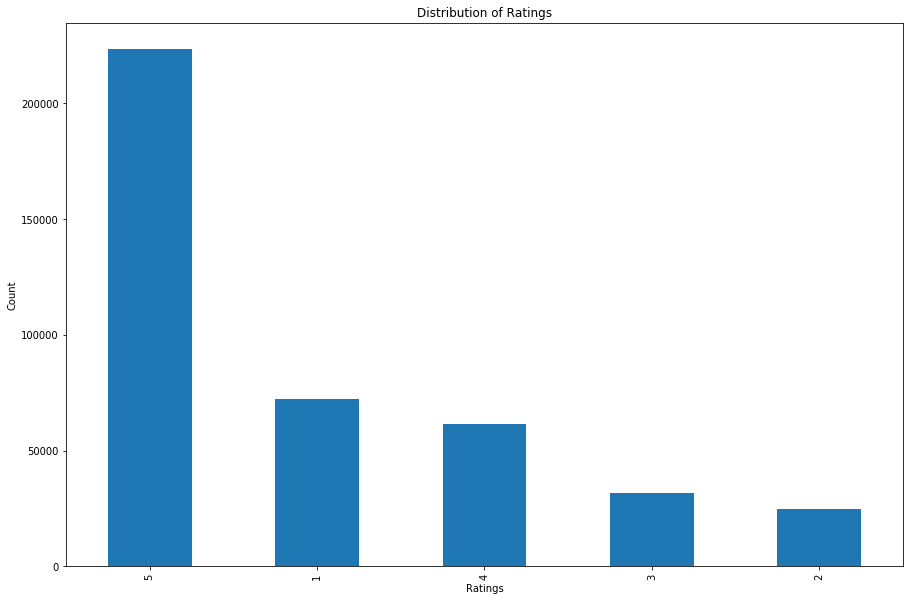

In [4]:
# Data Visualization

plt.figure(figsize=(15,10))
df['Rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

Distribution of various unique brands of phones sold

Text(0.5, 1.0, 'Number of Unique Brand Phone sold')

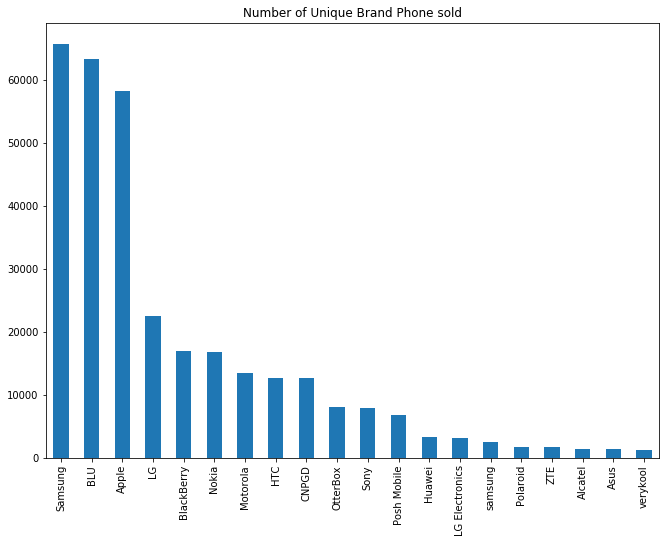

In [5]:
plt.figure(figsize=(11,8))
df['Brand Name'].value_counts()[:20].plot(kind='bar')
plt.title('Number of Unique Brand Phone sold')

Distribution of Reviews length

Text(0, 0.5, 'Count')

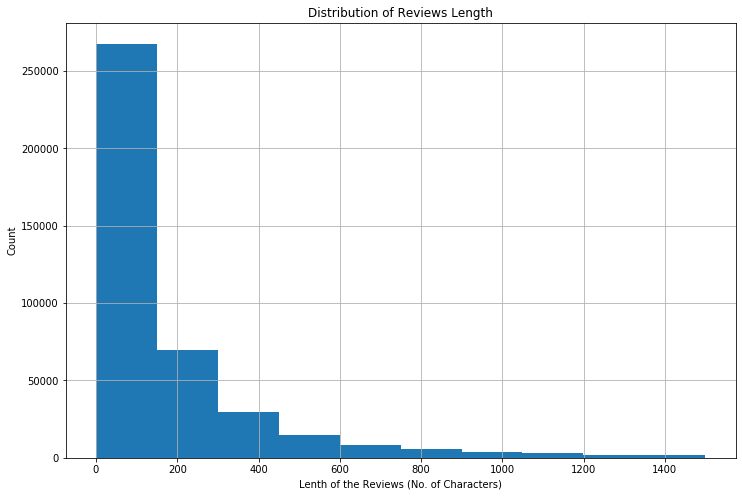

In [6]:
# Distribution of Reviews length

review_length= df['Reviews'].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length <1500].hist()
plt.title("Distribution of Reviews Length")
plt.xlabel("Lenth of the Reviews (No. of Characters)")
plt.ylabel('Count')

Data Cleaning and Preprocessing

In [7]:
# Taking a sample of the datframe for modelling
df= df.sample(frac=0.3)

# Dropping the entries with null values.
df.dropna(inplace= True)

# Creating a threshold of ratings of being not 3 as ratings=3 belongs to an neutral sentiment
df= df[df['Rating']!= 3]

# Adding a column to the dataframe where sentiment if is greater than 3, it reflects 1 else 0.
df['Sentiment']= np.where(df['Rating']> 3, 1, 0)

df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
81629,"ASUS ZenFone 2 Unlocked Cellphone, 64GB, Gold ...",Asus,225.00,4,I got this yesterday. I really like this phone...,1.0,1
351453,Samsung Galaxy S5 Mini G800F 16GB Unlocked Cel...,Samsung,239.00,2,"The cellphone is very slow, it never use 4G LT...",0.0,0
160183,"BLU VIVO 5 Smartphone -5.5"" 4G LTE GSM Unlocke...",BLU,199.99,5,Great phone. Screen looks really good and batt...,0.0,1
199402,"Huawei Ascend G730 (Black) 5.5"" GSM 3G (Factor...",Huawei,80.00,5,muy bueno,0.0,1
228254,LG KP500 Cookie Unlocked Phone with 3.2 MP Cam...,LG Electronics MobileComm USA,79.00,4,NICE PHONE OVERALL EXCEPT THAT THE TOUCH SCREE...,0.0,1
35328,Apple iPhone 5c 8GB Unlocked GSM Smartphone - ...,Apple,115.00,5,I'm so happy but it takes a really small SIM c...,0.0,1
33271,Apple iPhone 5c 32GB (Yellow) - AT&T,Apple,224.77,5,Great phone!!!!! Its definitely a keeper,0.0,1
628,"5.5"" Phone Unlocked Dual Sim Quad Core-JUNING ...",JUNING,99.99,1,I wrote more positive review for this phone bu...,0.0,0
309220,"Samsung Galaxy Exhibit 4G (T-Mobile), t679",Samsung,119.99,5,great product,0.0,1
104241,BLU Advance 4.0L Unlocked Smartphone -Global G...,BLU,149.99,5,It worked greatTook it to Costa Rica and stuck...,2.0,1


In [8]:
# Creating a Train test Split in order to train it for modeling and validation

X_train, X_test, y_train, y_test= train_test_split(df['Reviews'],
                                                   df['Sentiment'],
                                                   test_size= 0.2,
                                                   random_state=0)


Text Preprocessing

In [9]:
# Defining a function which takes raw text as input and give a cleaned text as output with removed html tags,
# special characters, perform stemming on words and then finally split the text

def text_clean(raw_text, remove_stopwords=False, stemming= False, split_text= False):
    
    # BeautifulSoup is used to remove the HTML tags if any
    text= BeautifulSoup(raw_text, 'lxml').get_text()
    
    # keeping only the letters without any special characters with the help of RegEx.
    letters_only= re.sub("[^a-zA-Z]", " ", text)
    
    # Converting all letters into lowercase for better identification further
    words= letters_only.lower().split()
    
    # Removing the common adjectives and verbs with stopwords
    if remove_stopwords:
        stops= set(stopwords.words('english'))
        
        # Storing the cleaned words a list
        words= [w for w in words if not w in stops]
        
    if stemming== True:
        
        # Performing stemming of the words in order to bring words to their origin form.
        Stemmer= SnowballStemmer('english')
        words= [Stemmer.stem(w) for w in words]
        
    if split_text== True:
        return(words)
    
    return(" ".join(words))

In [10]:
# Defining a functions which outputs all model-evaluation metrics scores

def model_evaluation(predictions):
    
    print("\n Accuracy in Validation set: ", accuracy_score(y_test, predictions))
    print("\n AUC Score: ", roc_auc_score(y_test, predictions))
    print("\n Classification Report: \n", metrics.classification_report(y_test, predictions))
    print("\n Confusion Matrix: \n", metrics.confusion_matrix(y_test, predictions))

In [11]:
# Initialising empty lists to append cleaned training and test sets

X_train_cleaned= []
X_test_cleaned= []

for d in X_train:
    X_train_cleaned.append(text_clean(d))
    
for d in X_test:
    X_test_cleaned.append(text_clean(d))

C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.amazon.com/dp/B00QF5QJR2/ref=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You shou

<h3>Multinomial Naive Bayes with CountVectorizer</h3>

After the text preprocessing, it's now time for converting our texts into numerical representations i.e. in the form of vectors

    
 

In [12]:
# Instantiating CountVectorizer
count_vect= CountVectorizer()

# Fitting an transforming the cleaned independent train data into the CountVectorizer model
X_train_count_vec=count_vect.fit_transform(X_train_cleaned)

# Instantiating Multinomial Naive Bayes Machine Learning Model to check the accuracy
mnb= MultinomialNB()

# Fitting the model 
mnb.fit(X_train_count_vec, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
# Performing predictions according to Multinomial Naive Bayes Model
predictions= mnb.predict(count_vect.transform(X_test_cleaned))

# Checking the accuracy metrices scores
model_evaluation(predictions)


 Accuracy in Validation set:  0.9220084315209166

 AUC Score:  0.8867944786328306

 Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      4620
           1       0.94      0.96      0.95     13882

    accuracy                           0.92     18502
   macro avg       0.90      0.89      0.89     18502
weighted avg       0.92      0.92      0.92     18502


 Confusion Matrix: 
 [[ 3772   848]
 [  595 13287]]


<h3>Logistic Regression with TfidfVectorizer</h3>

As, sometimes it may happen, certain meaningless information get collected out with all bag of words whose frequent appearance in the dataset decreases the model accuracy. So, instead of just of counting the words asm vectors we could introduce TfidfVectorizer to scale down the frequently appearing words(vectors) in our corpus

In [14]:
# Instantiating TfidfVectorizer
tfidf= TfidfVectorizer(min_df=5)

# Fitting and transforming the given corpus of trained data with TfidfVectorizer 
X_train_tfidf= tfidf.fit_transform(X_train)


# Instantiating Logistic Regression Machine Learning Model
lr= LogisticRegression()

# Fitting the model to trained and transformed data
lr.fit(X_train_tfidf, y_train)

# Performing Predictions with test data
predictions= lr.predict(tfidf.transform(X_test_cleaned))

# Evaluating model predictions with accuracy metrices scores
model_evaluation(predictions)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 Accuracy in Validation set:  0.9401145822073289

 AUC Score:  0.9120743888968929

 Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4620
           1       0.95      0.97      0.96     13882

    accuracy                           0.94     18502
   macro avg       0.93      0.91      0.92     18502
weighted avg       0.94      0.94      0.94     18502


 Confusion Matrix: 
 [[ 3955   665]
 [  443 13439]]


In [15]:
# Building a pipeline with different parameters values for the estimators and 
# finding out the best values to perform Logistic Regression with TfidfVectorizer with help of GridSearch algorithm


# Building the pipeline
estimators= [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]

# Instantiating Pipeline
model= Pipeline(estimators)

# Creating Parameters ranges
params= {"lr__C": [0.1,1,10],
         "tfidf__min_df": [1,3],
         "tfidf__max_features": [1000, None],
         "tfidf__ngram_range": [(1,1), (1,2)],
         "tfidf__stop_words": [None, 'english']}

# Instantiating GridSearch
grid= GridSearchCV(estimator= model, param_grid= params, scoring="accuracy", n_jobs=-1)

# Fitting Grid Search to traiing data
grid.fit(X_train_cleaned, y_train)

# Observing best parameters values for our model
print("Best Parameters: ", grid.best_params_)

# Performing prediction with Grid Search Estimators and parameters
predictions= grid.predict(X_test_cleaned)

# Checking Model Accuracy with metrices scoring
model_evaluation(predictions)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best Parameters:  {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

 Accuracy in Validation set:  0.9658955788563398

 AUC Score:  0.9511337051749096

 Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      4620
           1       0.97      0.98      0.98     13882

    accuracy                           0.97     18502
   macro avg       0.96      0.95      0.95     18502
weighted avg       0.97      0.97      0.97     18502


 Confusion Matrix: 
 [[ 4258   362]
 [  269 13613]]


<h3>Word2Vec</h3>

Another major approach for text classification is Word2Vec model which takes into account the weight of the words(vectors) in a given corpus

In [16]:
# Loading a tokenizer into our model which will convert our raw text into parsed sentences 
tokenizer= nltk.data.load('tokenizers/punkt/english.pickle')


# Defining a function which takes the review text, tokenizer into as input and remove the stopwords wherever needed and 
# provides us the poarsed sentences as output

def parseSent(review, tokenizer, remove_stopwords= False):
    
    # Tokenizing the reviews 
    raw_sentences= tokenizer.tokenize(review.strip())
    
    # Initialising the list of sentences
    sentences=[]
    
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            
            # Appending the cleaned setences into the sentences list
            sentences.append(text_clean(raw_sentence, remove_stopwords, split_text= True))
    return sentences

# Initialiing an empty list in order to append parsed sentences into it
sentences=[]
for review in X_train_cleaned:
    sentences+= parseSent(review, tokenizer)
    


In [17]:
num_features= 300
min_word_count= 10
num_workers= 4
context= 10
downsampling= 1e-3

w2v= Word2Vec(sentences, workers= num_workers, size= num_features, min_count= min_word_count, window= context, sample= downsampling)
w2v.init_sims(replace= True)
w2v.save("w2v_300features_10minwordcounts_10context")

print("No. of words in vocabulary list: ", len(w2v.wv.index2word))

No. of words in vocabulary list:  6594


In [18]:
# Defining a function which takes the reviews text, model and number of features as input and
# return the feature vectors

def makeFeatureVec(review, model, num_features):
    
    featureVec= np.zeros((num_features,), dtype="float32")
    nwords= 0
    index2word_set= set(model.wv.index2word)
    
    isZeroVec= True
    for word in review:
        if word in index2word_set:
            nwords= nwords+1
            featureVec= np.add(featureVec, model[word])
            isZeroVec= False
    if isZeroVec == False:
            featureVec= np.divide(featureVec, nwords)
        
    return featureVec

# defining another function which takes reviews, model and number of features as input and return the feature vectors from the review text as output

def getAvgFeatureVecs(reviews,model, num_features):
    
    counter= 0
    reviewFeatureVecs= np.zeros((len(reviews), num_features), dtype='float32')
    
    for review in reviews:
        reviewFeatureVecs[counter]= makeFeatureVec(review, model, num_features)
        counter= counter+1
        

        return reviewFeatureVecs

In [19]:
# Initializing an empty list to append the cleaned tarining set to it

X_train_cleaned=[]
for review in X_train:
    X_train_cleaned.append(text_clean(review, remove_stopwords= True, split_text= True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)

X_test_cleaned= []
for review in X_test:
    X_test_cleaned.append(text_clean(review, remove_stopwords= True, split_text= True))
testVector= getAvgFeatureVecs(X_test_cleaned, w2v, num_features)

C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.amazon.com/dp/B00QF5QJR2/ref=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You shou

<h3>Random Forest Classification</h3>

In [20]:
# Instantiating Random Forest Classifier
rf= RandomForestClassifier(n_estimators= 100)

# Fitting the model to training data
rf.fit(trainVector, y_train)

# Perfoming prediction on test data(vectors)
predictions= rf.predict(testVector)

# Model evaluation using various accuracy metrices
model_evaluation(predictions)


 Accuracy in Validation set:  0.7502972651605232

 AUC Score:  0.5

 Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      4620
           1       0.75      1.00      0.86     13882

    accuracy                           0.75     18502
   macro avg       0.38      0.50      0.43     18502
weighted avg       0.56      0.75      0.64     18502



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Confusion Matrix: 
 [[    0  4620]
 [    0 13882]]


__Comments:__

So, We ran three models in order to check the accuracy score for sentiment analysis and We observed that highest accuracy on the validation set was seen by the Regularised Logisitic Regression with TfidfVectorizer with an accuracy score of 98%.

- Word Clouds of Postive and Negative Sentiments associated with each brands

In [23]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass


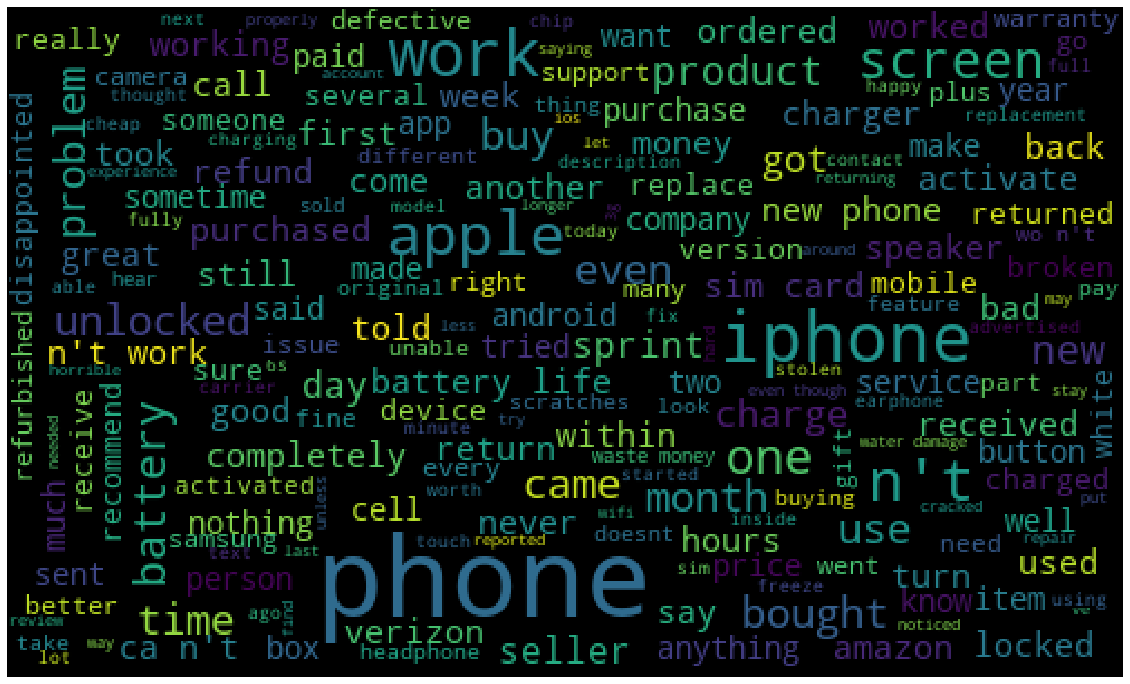

In [25]:
create_word_cloud(brand= 'Apple', sentiment=0)

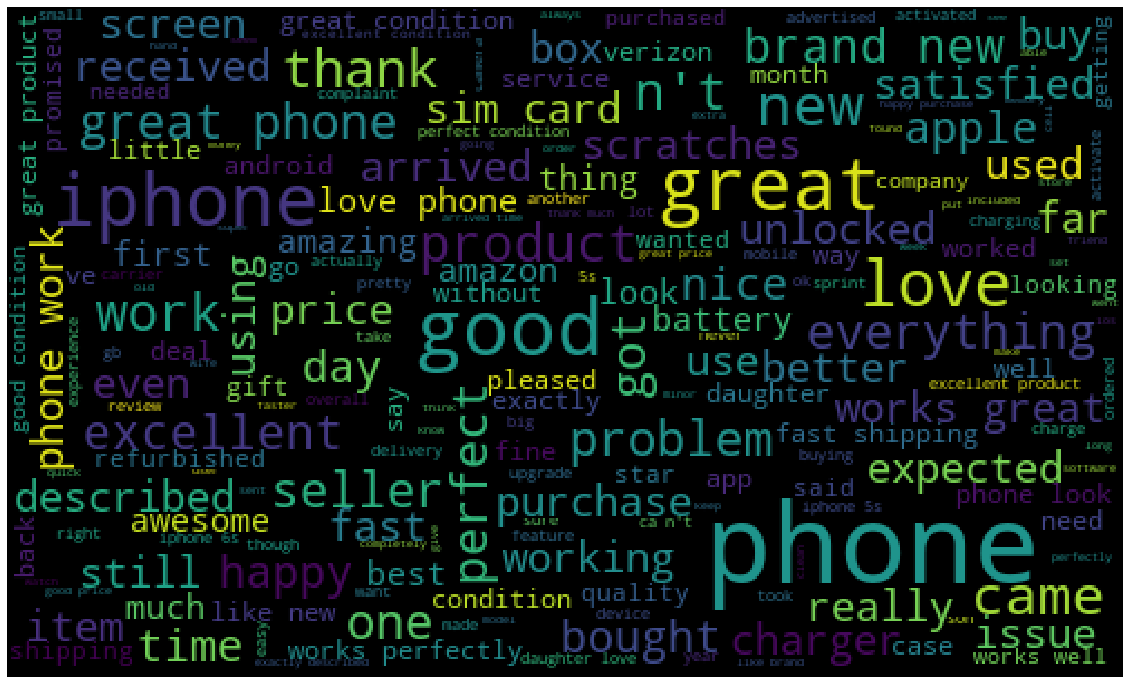

In [26]:
create_word_cloud(brand='Apple', sentiment=1)

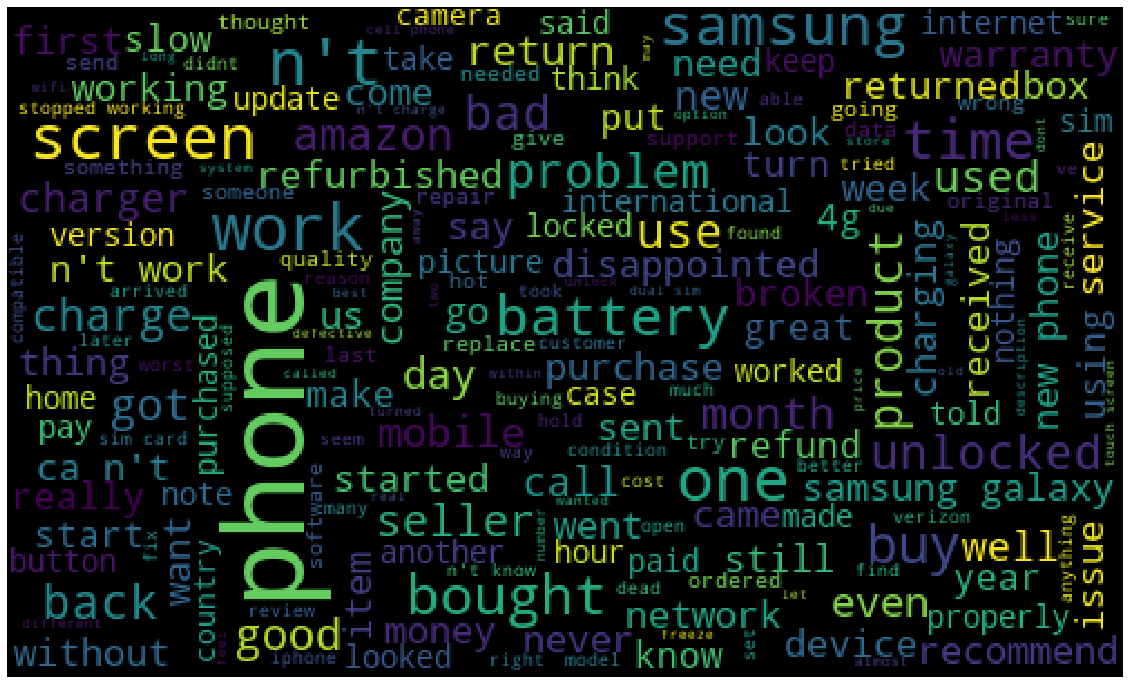

In [27]:
create_word_cloud(brand='Samsung', sentiment=0)

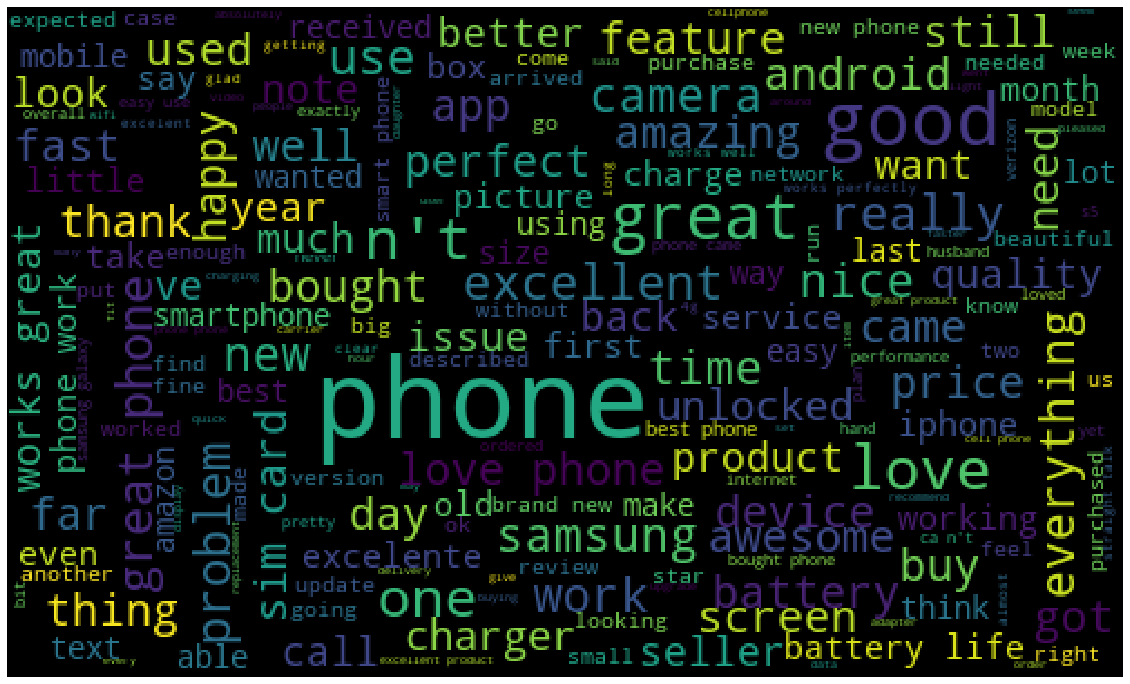

In [29]:
create_word_cloud(brand= 'Samsung', sentiment=1)